In [1]:
from functools import partial
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
from uncertainty_testbed.generators.data_generator_explicit import AnalyticBinaryClassGenerator
from uncertainty_testbed.utilities.functions import map_to_constant
from uncertainty_testbed.uncertainty_models.mc_dropout import MCDropoutLayer, MCDropoutKerasClassification

2022-04-25 14:44:28.316972: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-25 14:44:28.317003: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [7]:
# generate some data
s = partial(map_to_constant, c=0.1)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="gauss", threshold=0.5,
                                  noise_distribution="gauss", noise_scale=s)
x, y = eg.generate_labeled(256*1024)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:128*1024, :], y[:128*1024]
x_val, y_val = x[128*1024:, :], y[128*1024:]

In [8]:
# train a Keras MLP
model = keras.Sequential()
#model.add(keras.layers.Dropout(0.25))
#model.add(keras.layers.Dense(40, activation="relu"))
#model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(40, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(
    optimizer=keras.optimizers.Nadam(learning_rate=3e-5),
    loss="binary_crossentropy",
    metrics=["accuracy", "AUC"]
)
history = model.fit(
    x_train,
    y_train,
    epochs=60,
    batch_size=256,
    validation_data=(x_val, y_val)
)

Epoch 1/60
512/512 [==============================] - 4s 5ms/step - loss: 0.6609 - accuracy: 0.6122 - auc: 0.6697 - val_loss: 0.6115 - val_accuracy: 0.7815 - val_auc: 0.8778
Epoch 2/60
512/512 [==============================] - 3s 5ms/step - loss: 0.5827 - accuracy: 0.7251 - auc: 0.8060 - val_loss: 0.4738 - val_accuracy: 0.8608 - val_auc: 0.9431
Epoch 3/60
512/512 [==============================] - 3s 6ms/step - loss: 0.4620 - accuracy: 0.8086 - auc: 0.8890 - val_loss: 0.3142 - val_accuracy: 0.9120 - val_auc: 0.9750
Epoch 4/60
512/512 [==============================] - 2s 5ms/step - loss: 0.3554 - accuracy: 0.8560 - auc: 0.9312 - val_loss: 0.2073 - val_accuracy: 0.9409 - val_auc: 0.9884
Epoch 5/60
512/512 [==============================] - 2s 5ms/step - loss: 0.2879 - accuracy: 0.8833 - auc: 0.9520 - val_loss: 0.1519 - val_accuracy: 0.9555 - val_auc: 0.9934
Epoch 6/60
512/512 [==============================] - 2s 5ms/step - loss: 0.2453 - accuracy: 0.9007 - auc: 0.9642 - val_loss: 0.12

Epoch 48/60
512/512 [==============================] - 2s 4ms/step - loss: 0.0626 - accuracy: 0.9748 - auc: 0.9975 - val_loss: 0.0400 - val_accuracy: 0.9831 - val_auc: 0.9991
Epoch 49/60
512/512 [==============================] - 2s 4ms/step - loss: 0.0635 - accuracy: 0.9744 - auc: 0.9974 - val_loss: 0.0400 - val_accuracy: 0.9832 - val_auc: 0.9991
Epoch 50/60
512/512 [==============================] - 2s 4ms/step - loss: 0.0609 - accuracy: 0.9751 - auc: 0.9976 - val_loss: 0.0399 - val_accuracy: 0.9832 - val_auc: 0.9991
Epoch 51/60
512/512 [==============================] - 2s 4ms/step - loss: 0.0598 - accuracy: 0.9762 - auc: 0.9977 - val_loss: 0.0397 - val_accuracy: 0.9832 - val_auc: 0.9991
Epoch 52/60
512/512 [==============================] - 2s 4ms/step - loss: 0.0590 - accuracy: 0.9763 - auc: 0.9978 - val_loss: 0.0395 - val_accuracy: 0.9833 - val_auc: 0.9991
Epoch 53/60
512/512 [==============================] - 2s 4ms/step - loss: 0.0577 - accuracy: 0.9766 - auc: 0.9979 - val_loss

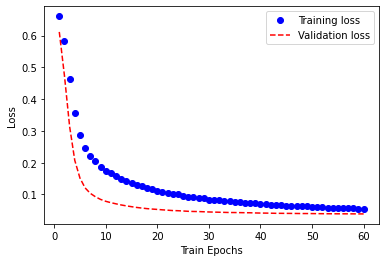

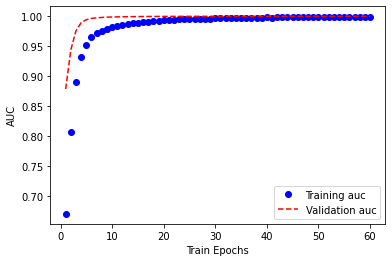

In [9]:
# inspect metrics
history_dict = history.history
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
auc = history_dict["auc"]
val_auc = history_dict["val_auc"]
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "r--", label="Validation loss")
plt.xlabel("Train Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, auc, "bo", label="Training auc")
plt.plot(epochs, val_auc, "r--", label="Validation auc")
plt.xlabel("Train Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

### Tuning notes: 

`100000 train/ 20000 validation`

Best values

* model: 0.25, 20, 0.25, 20, 0.25, 20, 0.25, 1 / batch: 512 / lr: 5e-5
* Epoch 9/17 val_loss: 0.4959 - val_accuracy: 0.9551 - val_auc: 0.9926

* model: 0.25, 30, 0.25, 30, 0.25, 30, 0.25, 1 / batch: 512 / lr: 5e-5
* Epoch 11/17 val_loss: 0.4413 - val_accuracy: 0.9657 - val_auc: 0.9978

`128*1024 train / 128*1024 test`

Best values

* model: 0.25, 40, 0.25, 40, 0.25, 30, 0.25, 30, 0.25, 1 / batch: 256 / lr: 1e-4
* Epoch 8/40 **val_loss: 0.2270**  - val_accuracy: 0.9789 - val_auc: 0.9984

* model: 0.25, 40, 0.25, 40, 0.25, 40, 0.25, 30, 0.25, 30, 0.25, 1 / batch: 256 / lr: 5e-5
* Epoch 7/40 **val_loss: 0.2332** - val_accuracy: 0.9747 - val_auc: 0.9979

* model: 0.25, 40, 0.25, 40, 0.25, 40, 0.25, 30, 0.25, 30, 0.25, 1 / batch: 256 / lr: 3e-5
* Epoch 23/40 **val_loss: 0.2441** - val_accuracy: 0.9793 - val_auc: 0.9985

* model: 30, 0.25, 30, 0.25, 30, 0.25, 1 / batch: 256 / lr: 3e-5
* Epoch 60/60 **val_loss: 0.0122** - val_accuracy: 0.9972 - val_auc: 1.0000

* model: 40, 0.25, 30, 0.25, 30, 0.25, 30, 0.25, 1 / batch: 256 / lr: 3e-5
* Epoch 60/60 **val_loss: 0.0132** - val_accuracy: 0.9966 - val_auc: 1.0000


In [14]:
scores = eg.get_scores(x_val[:1000,:])
ix_srt = np.argsort(scores)
probs = eg.get_probabilities(x_val[:1000,:])[1]

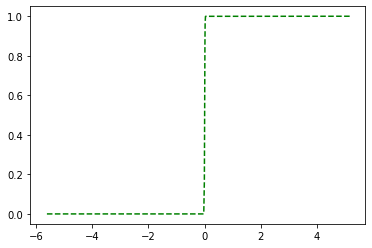

In [15]:
plt.plot(scores[ix_srt[::-1]], probs[ix_srt[::-1]], '--g')
plt.show()

(array([ 10.,  21.,  62., 156., 207., 227., 163.,  90.,  50.,  14.]),
 array([-5.66738654, -4.58481758, -3.50224861, -2.41967965, -1.33711068,
        -0.25454172,  0.82802725,  1.91059621,  2.99316518,  4.07573415,
         5.15830311]),
 <BarContainer object of 10 artists>)

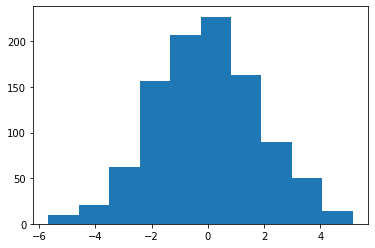

In [16]:
plt.hist(scores)

(array([511.,   2.,   0.,   1.,   0.,   0.,   0.,   0.,   1., 485.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

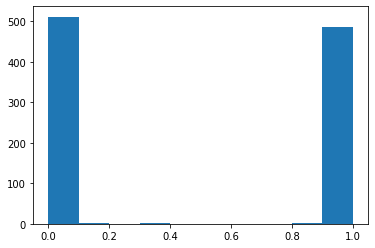

In [17]:
plt.hist(probs)